In [2]:
import pysindy as ps
import numpy as np
from CAE_NIF import CAE
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from tensorflow.keras import layers, models, optimizers

In [3]:
data = np.load('StatesGP0.01dt4000.npy')
data = data.reshape(4000,2000,1)
autoencoder2 = CAE(2,2000)
#optimizer = optimizers.legacy.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, name='Adam')
#autoencoder.compile(optimizer=optimizer, loss='mse')
#autoencoder.fit(data, data, epochs=300, validation_data=(data,data), batch_size=8)

In [4]:
autoencoder2.load_weights("./saved_weights/PySINDY-{}/QHOGPLat".format(0)).expect_partial()
#outpt = autoencoder2.predict_on_batch(data)
#print(outpt.shape)
predict = autoencoder2.predict_on_batch(data)

(4000, 2)


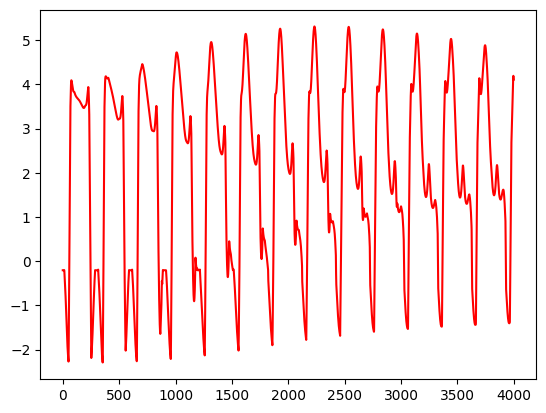

In [5]:
latent = autoencoder2.encode(data)
time_arr = np.linspace(0,40,4000)
spline1 = UnivariateSpline(time_arr, latent[:,0],s=0)
spline2 = UnivariateSpline(time_arr, latent[:,1],s=4.9)
spline3 = UnivariateSpline(time_arr, latent[:,2], s=10)
spline4 = UnivariateSpline(time_arr, latent[:,3], s=10)
l1 = spline1(time_arr)
l2 = spline2(time_arr)
l3 = spline3(time_arr)
l4 = spline4(time_arr)
lat = np.column_stack([l1,l2])
print(lat.shape)
plt.plot(lat[:,0], label='Smoothed Curve', color='r')
#plt.plot(latent[:], label='Normal Curve', color='b')

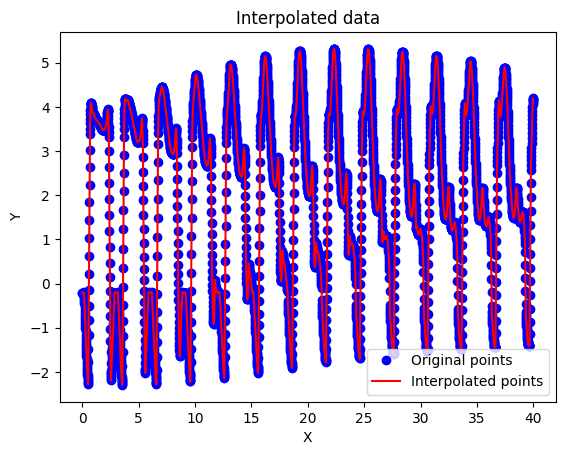

In [66]:
NT=40000
lat_long = np.zeros([NT,4])
for i in range(4):
    t = np.linspace(0, 40, 4000)  # Assuming x values are evenly spaced
    f = interp1d(t, latent[:,i], kind='cubic')
    x_new = np.linspace(0, 40, NT)  # Increase the number of points to 16000 for example
    y_new = f(x_new)
    lat_long[:,i] = y_new

# Plot original data
plt.plot(t, latent[:,0], 'bo', label='Original points')

# Plot interpolated data
plt.plot(x_new, lat_long[:,0], 'r', label='Interpolated points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Interpolated data')
#plt.ylim(10,11.5)
plt.show()

In [68]:
noise_mean = 0
noise_std = 0.001

# Generate Gaussian noise
noise = np.random.normal(noise_mean, noise_std, lat_long.shape)

# Add the noise to the original array
noisy_array = lat_long + noise

# Print the original and noisy arrays
print("Original Array:\n", lat_long)
print("Noisy Array:\n", noisy_array)

Original Array:
 [[-0.2048642   0.24361254 -0.08440924 -0.33667991]
 [-0.2048642   0.24361254 -0.08440924 -0.33667991]
 [-0.2048642   0.24361254 -0.08440924 -0.33667991]
 ...
 [ 4.11565151 -1.50732342 -2.47997514  0.60956292]
 [ 4.11129697 -1.50531557 -2.48214075  0.60984796]
 [ 4.10691309 -1.50329638 -2.48426914  0.6101222 ]]
Noisy Array:
 [[-0.20254396  0.24414475 -0.08329734 -0.3364764 ]
 [-0.20351626  0.24336346 -0.08377358 -0.33773687]
 [-0.20636243  0.24435038 -0.08481413 -0.33582671]
 ...
 [ 4.11560119 -1.50849451 -2.47944568  0.60835534]
 [ 4.11257514 -1.50728154 -2.48382382  0.60863977]
 [ 4.10624104 -1.50230788 -2.48397503  0.6108102 ]]


In [70]:
def finite_difff(points, time):
    t = time
    X=points
    finite_diff = np.zeros_like(X)
    for i in range(finite_diff.shape[1]):
        for j in range(finite_diff.shape[0]):
            if j < 4:
                finite_diff[j,i] = (-25/12*X[j,i] + 4*X[j+1,i] -3*X[j+2,i] + 4/3*X[j+3,i] - 1/4*X[j+4,i])/(t[1]-t[0])
            elif j > finite_diff.shape[0]-4:
                finite_diff[j,i] = (25/12*X[j,i] - 4*X[j-1,i] +3*X[j-2,i] - 4/3*X[j-3,i] + 1/4*X[j-4,i])/(t[1]-t[0])
            else:
                finite_diff[j,i] = (-1/60*X[j-3,i] + 3/20*X[j-2,i] -3/4*X[j-1,i] + 3/4*X[j+1,i] - 3/20*X[j+2,i] + 1/60*X[j+3,i])/(t[1]-t[0])
    return finite_diff

first_diff = finite_difff(lat_long, x_new)
second_diff = finite_difff(first_diff,x_new)

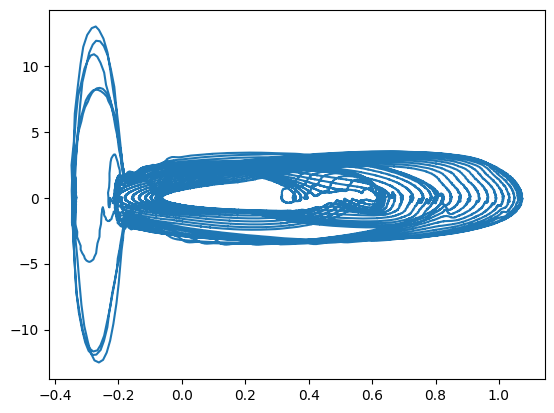

In [72]:
X = noisy_array
deriv = np.concatenate(([np.zeros(4)], np.diff(lat_long, axis=0) / (t[1]-t[0])))
time = 1
plt.plot(X[time:-time,3], first_diff[time:-time,3])
#plt.plot(finite_diff[time:-time])
#plt.plot(X[2000:-2000,0], deriv[2000:-2000,0])

0
1
2
3


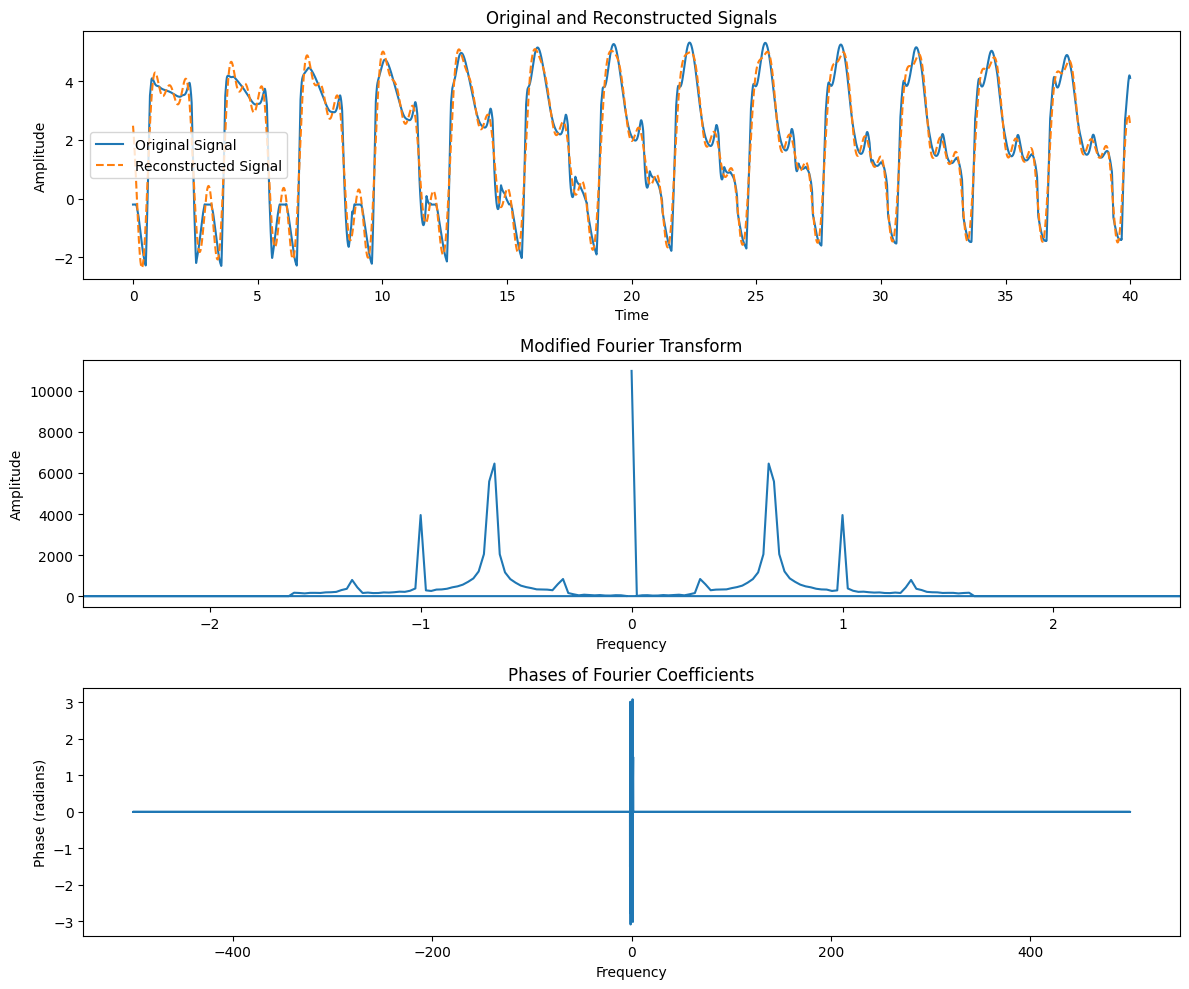

In [74]:
eq = []
X=lat_long
finite = None
for i in range(X.shape[1]):
    print(i)
    # Generate a sample signal
    t = np.linspace(0, 40, X.shape[0], endpoint=False)  # time points from 0 to 40 (exclusive) with 4000 samples
    signal = X[:,i]  # Example signal (replace with your data)
    # Compute Fourier transform
    fourier_transform = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), t[1] - t[0])  # compute frequency axis   
    # Example: Zeroing out frequencies above 'num' Hz
    num = 1.6
    fourier_transform[np.abs(freqs) > num] = 0
    
    # Extract amplitudes and phases
    amplitudes = np.abs(fourier_transform)
    phases = np.angle(fourier_transform)
    
    # Construct reconstructed signal
    t_large = np.linspace(0,40,X.shape[0])
    waveform = np.zeros_like(t_large)
    for j in range(len(freqs)):
        amplitude = amplitudes[j]
        phase = phases[j]
        freq = freqs[j]
        waveform += amplitude * np.cos(2 * np.pi * freq * t_large + phase)/X.shape[0]
    if i == 0:
        first_one = waveform
    eq.append(waveform)

finite = np.array(eq).T
# Plotting
plt.figure(figsize=(12, 10))

# Original and Reconstructed signal plot
plt.subplot(3, 1, 1)
plt.plot(t, X[:,0], label='Original Signal')
plt.plot(t_large, finite[:,0], label='Reconstructed Signal', linestyle='--')
plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Fourier transform plot
plt.subplot(3, 1, 2)
plt.plot(freqs, np.abs(fourier_transform))
plt.title('Modified Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(-num-1, num+1)

# Phase plot
plt.subplot(3, 1, 3)
plt.plot(freqs, phases)
plt.title('Phases of Fourier Coefficients')
plt.xlabel('Frequency')
plt.ylabel('Phase (radians)')
plt.tight_layout()
plt.show()

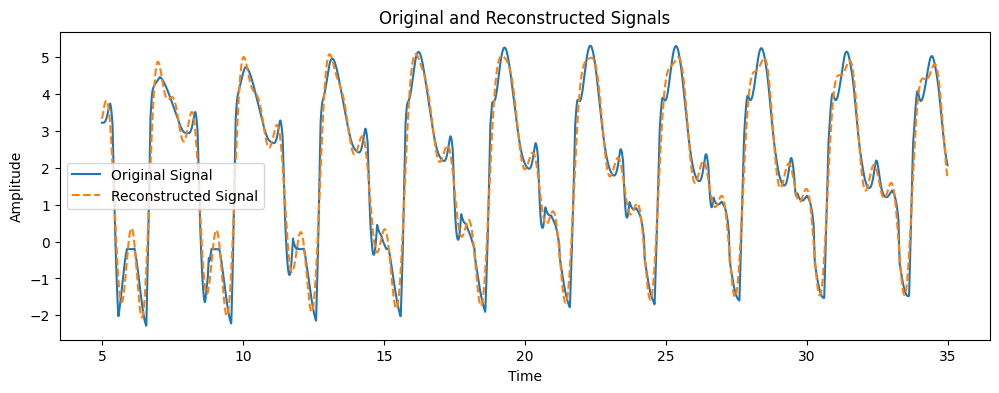

In [80]:
num=5000
plt.figure(figsize=(12, 4))
plt.plot(t[num:-num], X[num:-num,0], label='Original Signal')
plt.plot(t_large[num:-num], first_one[num:-num], label='Reconstructed Signal', linestyle='--')
plt.title('Original and Reconstructed Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

In [88]:
ti = t
time=2000
start=time
end = -time
num_lat = latent.shape[1]
first_deriv = finite_difff(finite,ti)
second_deriv = finite_difff(first_deriv,ti)
third_deriv = finite_difff(second_deriv,ti)
fourth_deriv = finite_difff(third_deriv,ti)
fifth_deriv = finite_difff(fourth_deriv,ti)
sixth_deriv = finite_difff(fifth_deriv,ti)
seventh_deriv = finite_difff(sixth_deriv,ti)
eighth_deriv = finite_difff(seventh_deriv,ti)
ninth_deriv = finite_difff(eighth_deriv,ti)


deriv=np.concatenate(([np.zeros(num_lat)], np.diff(finite, axis=0) / (ti[1]-ti[0])))
deriv2 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv, axis=0) / (ti[1]-ti[0])))
deriv3 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv2, axis=0) / (ti[1]-ti[0])))
deriv4 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv3, axis=0) / (ti[1]-ti[0])))
deriv5 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv4, axis=0) / (ti[1]-ti[0])))
deriv6 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv5, axis=0) / (ti[1]-ti[0])))
deriv7 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv6, axis=0) / (ti[1]-ti[0])))
deriv8 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv7, axis=0) / (ti[1]-ti[0])))
deriv9 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv8, axis=0) / (ti[1]-ti[0])))
deriv10 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv9, axis=0) / (ti[1]-ti[0])))
deriv11 = np.concatenate(([np.zeros(num_lat)], np.diff(deriv10, axis=0) / (ti[1]-ti[0])))

X_ = np.column_stack([finite,first_deriv,second_deriv,third_deriv,fourth_deriv,fifth_deriv,])

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=10, thresholder="l1", max_iter=50, normalize_columns=True, tol=1e-12
)
model = ps.SINDy(differentiation_method=ps.FiniteDifference(order=4), feature_library=ps.PolynomialLibrary(degree=1), 
         optimizer=ps.STLSQ(threshold=0.1,normalize_columns=False))

#model = ps.SINDy(feature_library=ode_lib, optimizer=ps.STLSQ(threshold=0.05,normalize_columns=False))
model.fit(X_[start:end], t=ti[1]-ti[0], ensemble=True, replace=False,n_models=10,quiet=True)
model.print()

(x0)' = 1.000 x4
(x1)' = 1.000 x5
(x2)' = 1.000 x6
(x3)' = 1.000 x7
(x4)' = 1.000 x8
(x5)' = 1.000 x9
(x6)' = 1.000 x10
(x7)' = 1.000 x11
(x8)' = 1.000 x12
(x9)' = 1.000 x13
(x10)' = 1.000 x14
(x11)' = 1.000 x15
(x12)' = 1.000 x16
(x13)' = 1.000 x17
(x14)' = 1.000 x18
(x15)' = 1.000 x19
(x16)' = 0.011 1 + -0.022 x3 + 1.000 x20
(x17)' = 1.000 x21
(x18)' = -0.038 x2 + -0.210 x3 + -0.125 x4 + -0.296 x5 + 0.010 x7 + 1.000 x22
(x19)' = 1.000 x23
(x20)' = 4174014.345 1 + -6492058.843 x0 + -13966925.236 x1 + 862210.182 x2 + 5900349.957 x3 + -148524.762 x4 + -343916.484 x5 + -22687.079 x6 + -14099.236 x7 + -568052.547 x8 + -1217886.467 x9 + 75481.638 x10 + 516892.100 x11 + -3765.059 x12 + -9170.134 x13 + -1359.964 x14 + -3051.303 x15 + -6805.061 x16 + -14434.155 x17 + 882.553 x18 + 6068.617 x19 + -0.710 x20 + -11.964 x21 + -18.841 x22 + -64.462 x23
(x21)' = 1879607.992 1 + -2989393.666 x0 + -6469192.188 x1 + 367820.291 x2 + 2616153.997 x3 + -110488.496 x4 + -232719.188 x5 + 23229.299 x6 + 1239

34999


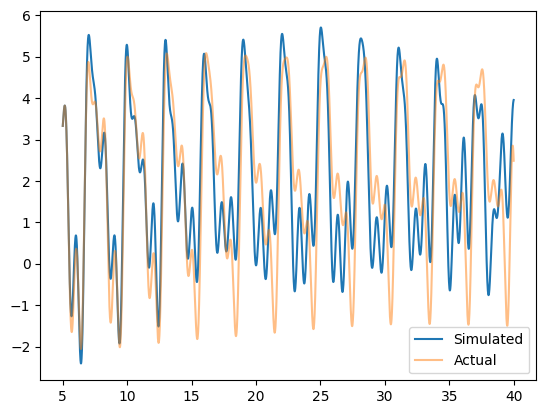

In [89]:
start = 5000
end = -1
x_simulated = model.simulate(X_[start], ti[start:end], integrator_kws={'atol': 1e-12, 'method': 'RK45', 'rtol': 1e-12}, interpolator_kws={})

print(len(x_simulated))
plt.plot(ti[start:end],x_simulated[:,0], label='Simulated')
plt.plot(ti[start:end],X_[start:end,0], alpha=0.5, label='Actual')
plt.legend()
plt.show()

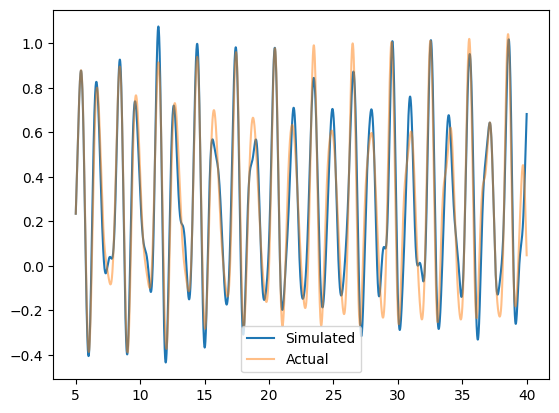

In [90]:
plt.plot(ti[start:end],x_simulated[:,3], label='Simulated')
plt.plot(ti[start:end],X_[start:end,3], alpha=0.5, label='Actual')
plt.legend()

In [28]:
first = finite_difff(lat_long, time_arr)
second = finite_difff(first, time_arr)
third = finite_difff(second, time_arr)
fourth = finite_difff(third, time_arr)
fifth = finite_difff(fourth, time_arr)
sixth = finite_difff(fifth, time_arr)
seventh = finite_difff(sixth, time_arr)
eighth = finite_difff(seventh, time_arr)

13999


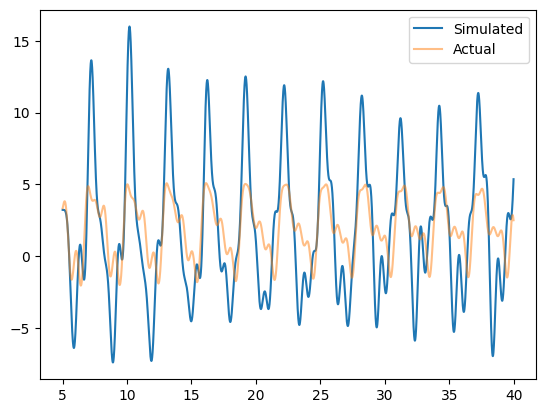

In [36]:
pred = np.column_stack([lat_long,first,second,third,fourth,fifth,])
start = 2000
end = -1
x_simulated = model.simulate(pred[start], ti[start:end], integrator_kws={'atol': 1e-12, 'method': 'RK45', 'rtol': 1e-12}, interpolator_kws={})

print(len(x_simulated))
plt.plot(ti[start:end],x_simulated[:,0], label='Simulated')
plt.plot(ti[start:end],X_[start:end,0], alpha=0.5, label='Actual')
plt.legend()
plt.show()